In [1]:

import numpy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from autogluon.tabular import TabularDataset, TabularPredictor

from helpers.experiment.constants import Paths_to_Directories


bkg_dir = Paths_to_Directories().path_to_raw_bkg_dir.joinpath("new")

label = "isSignal"

features = [
    "tfRedChiSqB0", 
    "deltaE", 
    "invM_K_pi_shifted",
    "K_p_kaonID", 
    "K_p_dr", 
    "K_p_dz", 
    "pi_m_dr", 
    "pi_m_dz", 
    "mu_p_dr", 
    "mu_p_dz", 
    "mu_p_muonID", 
    "mu_m_dr", 
    "mu_m_dz", 
    "mu_m_muonID",
]


variables = ["q_squared", "costheta_mu", "costheta_K", "chi"]


mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 400
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["figure.titlesize"] = 8
mpl.rcParams["figure.labelsize"] = 30
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{bm}\usepackage{amsmath}"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Computer Modern"]
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.titley"] = None
mpl.rcParams["axes.titlepad"] = 2
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.framealpha"] = 0
mpl.rcParams["legend.markerscale"] = 1
mpl.rcParams["legend.fontsize"] = 11.5

c:\Users\tetha\miniforge3\envs\autogluon_3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
training_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("sb_train.parquet")))
training_dataset[label] = training_dataset[label].fillna(value=0)

validation_signal_region_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("sr_eval.parquet")))
validation_signal_region_dataset[label] = validation_signal_region_dataset[label].fillna(value=0)

validation_signal_region_charge_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("charge_sr_bkg_eval.parquet")))
validation_signal_region_charge_dataset[label] = validation_signal_region_charge_dataset[label].fillna(value=0)

validation_signal_region_mix_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("mix_sr_bkg_eval.parquet")))
validation_signal_region_mix_dataset[label] = validation_signal_region_mix_dataset[label].fillna(value=0)

validation_sideband_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("sb_eval.parquet")))
validation_sideband_dataset[label] = validation_sideband_dataset[label].fillna(value=0)

validation_sideband_charge_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("charge_sb_bkg_eval.parquet")))
validation_sideband_charge_dataset[label] = validation_sideband_charge_dataset[label].fillna(value=0)

validation_sideband_mix_dataset = TabularDataset(pandas.read_parquet(bkg_dir.joinpath("mix_sb_bkg_eval.parquet")))
validation_sideband_mix_dataset[label] = validation_sideband_mix_dataset[label].fillna(value=0)


In [ ]:
predictor = TabularPredictor(label=label).fit(training_dataset[features+[label]], time_limit=1200, presets="best")

In [4]:
predictor = TabularPredictor.load("AutogluonModels/ag-20250826_021643")

In [5]:
preds_sr_val = predictor.predict_proba(validation_signal_region_dataset.drop(columns=[label])[features])
preds_sr_val_signal = preds_sr_val[validation_signal_region_dataset[label] == 1][1]
preds_sr_val_bkg = preds_sr_val[validation_signal_region_dataset[label] == 0][1]

In [6]:
plt.hist(preds_sr_val_signal, label=f"Signal ({len(preds_sr_val_signal)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sr_val_bkg, label=f"Bkg. ({len(preds_sr_val_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $M_{bc} > 5.27$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig("bkg_sup_sb_sr", bbox_inches="tight")
plt.close()

In [8]:
p_thresholds = numpy.linspace(0, 1, 130)

signal_counts = numpy.array([len(preds_sr_val_signal[preds_sr_val_signal > thresh]) for thresh in p_thresholds])
bkg_counts = numpy.array([len(preds_sr_val_bkg[preds_sr_val_bkg > thresh]) for thresh in p_thresholds])
ratio_bkg_to_signal = bkg_counts / signal_counts
bkg_frac = bkg_counts / (bkg_counts + signal_counts)
metric = signal_counts/numpy.sqrt(signal_counts+bkg_counts)

assert len(metric) == len(p_thresholds) == len(ratio_bkg_to_signal)
best_metric = numpy.nanmax(metric)
index_of_best_metric = numpy.nanargmax(metric)
best_threshold = p_thresholds[index_of_best_metric]
best_ratio = ratio_bkg_to_signal[index_of_best_metric]
best_bkg_frac = bkg_frac[index_of_best_metric]
print("best metric", best_metric)
print("best threshold: ", best_threshold)
print("best ratio: ", best_ratio)
print("best bkg. frac.: ", best_bkg_frac)

fig, axs = plt.subplots(2,  1, sharex=True, layout="compressed")

axs.flat[0].scatter(p_thresholds, ratio_bkg_to_signal, color="purple", s=3)
axs.flat[0].set_ylabel(r"$n_\text{bkg} / n_\text{sig}$", fontsize=13)
axs.flat[0].set_ylim(bottom=0)

axs.flat[1].set_xlabel("Cut Threshold", fontsize=13, labelpad=13)
axs.flat[1].set_ylabel(r"$n_\text{sig} / \sqrt{n_\text{sig} + n_\text{bkg}}$", fontsize=13)
axs.flat[1].scatter(p_thresholds, metric, color="red", s=3)
axs.flat[1].set_ylim(bottom=5)

plt.savefig("bkg_sup_ratio.png", bbox_inches="tight")
plt.close()


C:\Users\tetha\AppData\Local\Temp\ipykernel_703436\3248681345.py:5: RuntimeWarning: invalid value encountered in divide
  ratio_bkg_to_signal = bkg_counts / signal_counts
C:\Users\tetha\AppData\Local\Temp\ipykernel_703436\3248681345.py:6: RuntimeWarning: invalid value encountered in divide
  bkg_frac = bkg_counts / (bkg_counts + signal_counts)
C:\Users\tetha\AppData\Local\Temp\ipykernel_703436\3248681345.py:7: RuntimeWarning: invalid value encountered in divide
  metric = signal_counts/numpy.sqrt(signal_counts+bkg_counts)


best metric 19.75368401408998
best threshold:  0.7054263565891473
best ratio:  0.7862266857962698
best bkg. frac.:  0.44016064257028115


In [12]:
preds_sb_charge_val = predictor.predict_proba(validation_sideband_charge_dataset.drop(columns=[label])[features])
preds_sb_charge_val_bkg = preds_sb_charge_val[validation_sideband_charge_dataset[label]==0][1]

preds_sb_mix_val = predictor.predict_proba(validation_sideband_mix_dataset.drop(columns=[label])[features])
preds_sb_mix_val_bkg = preds_sb_mix_val[validation_sideband_mix_dataset[label]==0][1]

print("Befor bkg. suppression: ", len(preds_sb_mix_val_bkg) + len(preds_sb_charge_val_bkg))

num_pass_charge = len(preds_sb_charge_val_bkg[preds_sb_charge_val_bkg > best_threshold])
num_pass_mix = len(preds_sb_mix_val_bkg[preds_sb_mix_val_bkg > best_threshold])
print("Pass bkg. suppression: ", num_pass_charge+num_pass_mix)

charge_frac_after_bkg_sup = num_pass_charge / (num_pass_charge + num_pass_mix)
print("Charge fraction after bkg. suppression: ", charge_frac_after_bkg_sup)

Befor bkg. suppression:  46435
Pass bkg. suppression:  2681
Charge fraction after bkg. suppression:  0.5688176053711301


In [12]:
plt.hist(preds_sb_charge_val_bkg, label=f"Charge Bkg. ({len(preds_sb_charge_val_bkg)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sb_mix_val_bkg, label=f"Mix Bkg. ({len(preds_sb_mix_val_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $M_{bc} > 5.27$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig(bkg_dir.joinpath("bkg_sup_charge_mix"), bbox_inches="tight")
plt.close()

In [10]:
preds_sb_val = predictor.predict_proba(validation_sideband_dataset.drop(columns=[label])[features])
preds_sb_val_signal = preds_sb_val[validation_sideband_dataset[label] == 1][1]
preds_sb_val_bkg = preds_sb_val[validation_sideband_dataset[label] == 0][1]

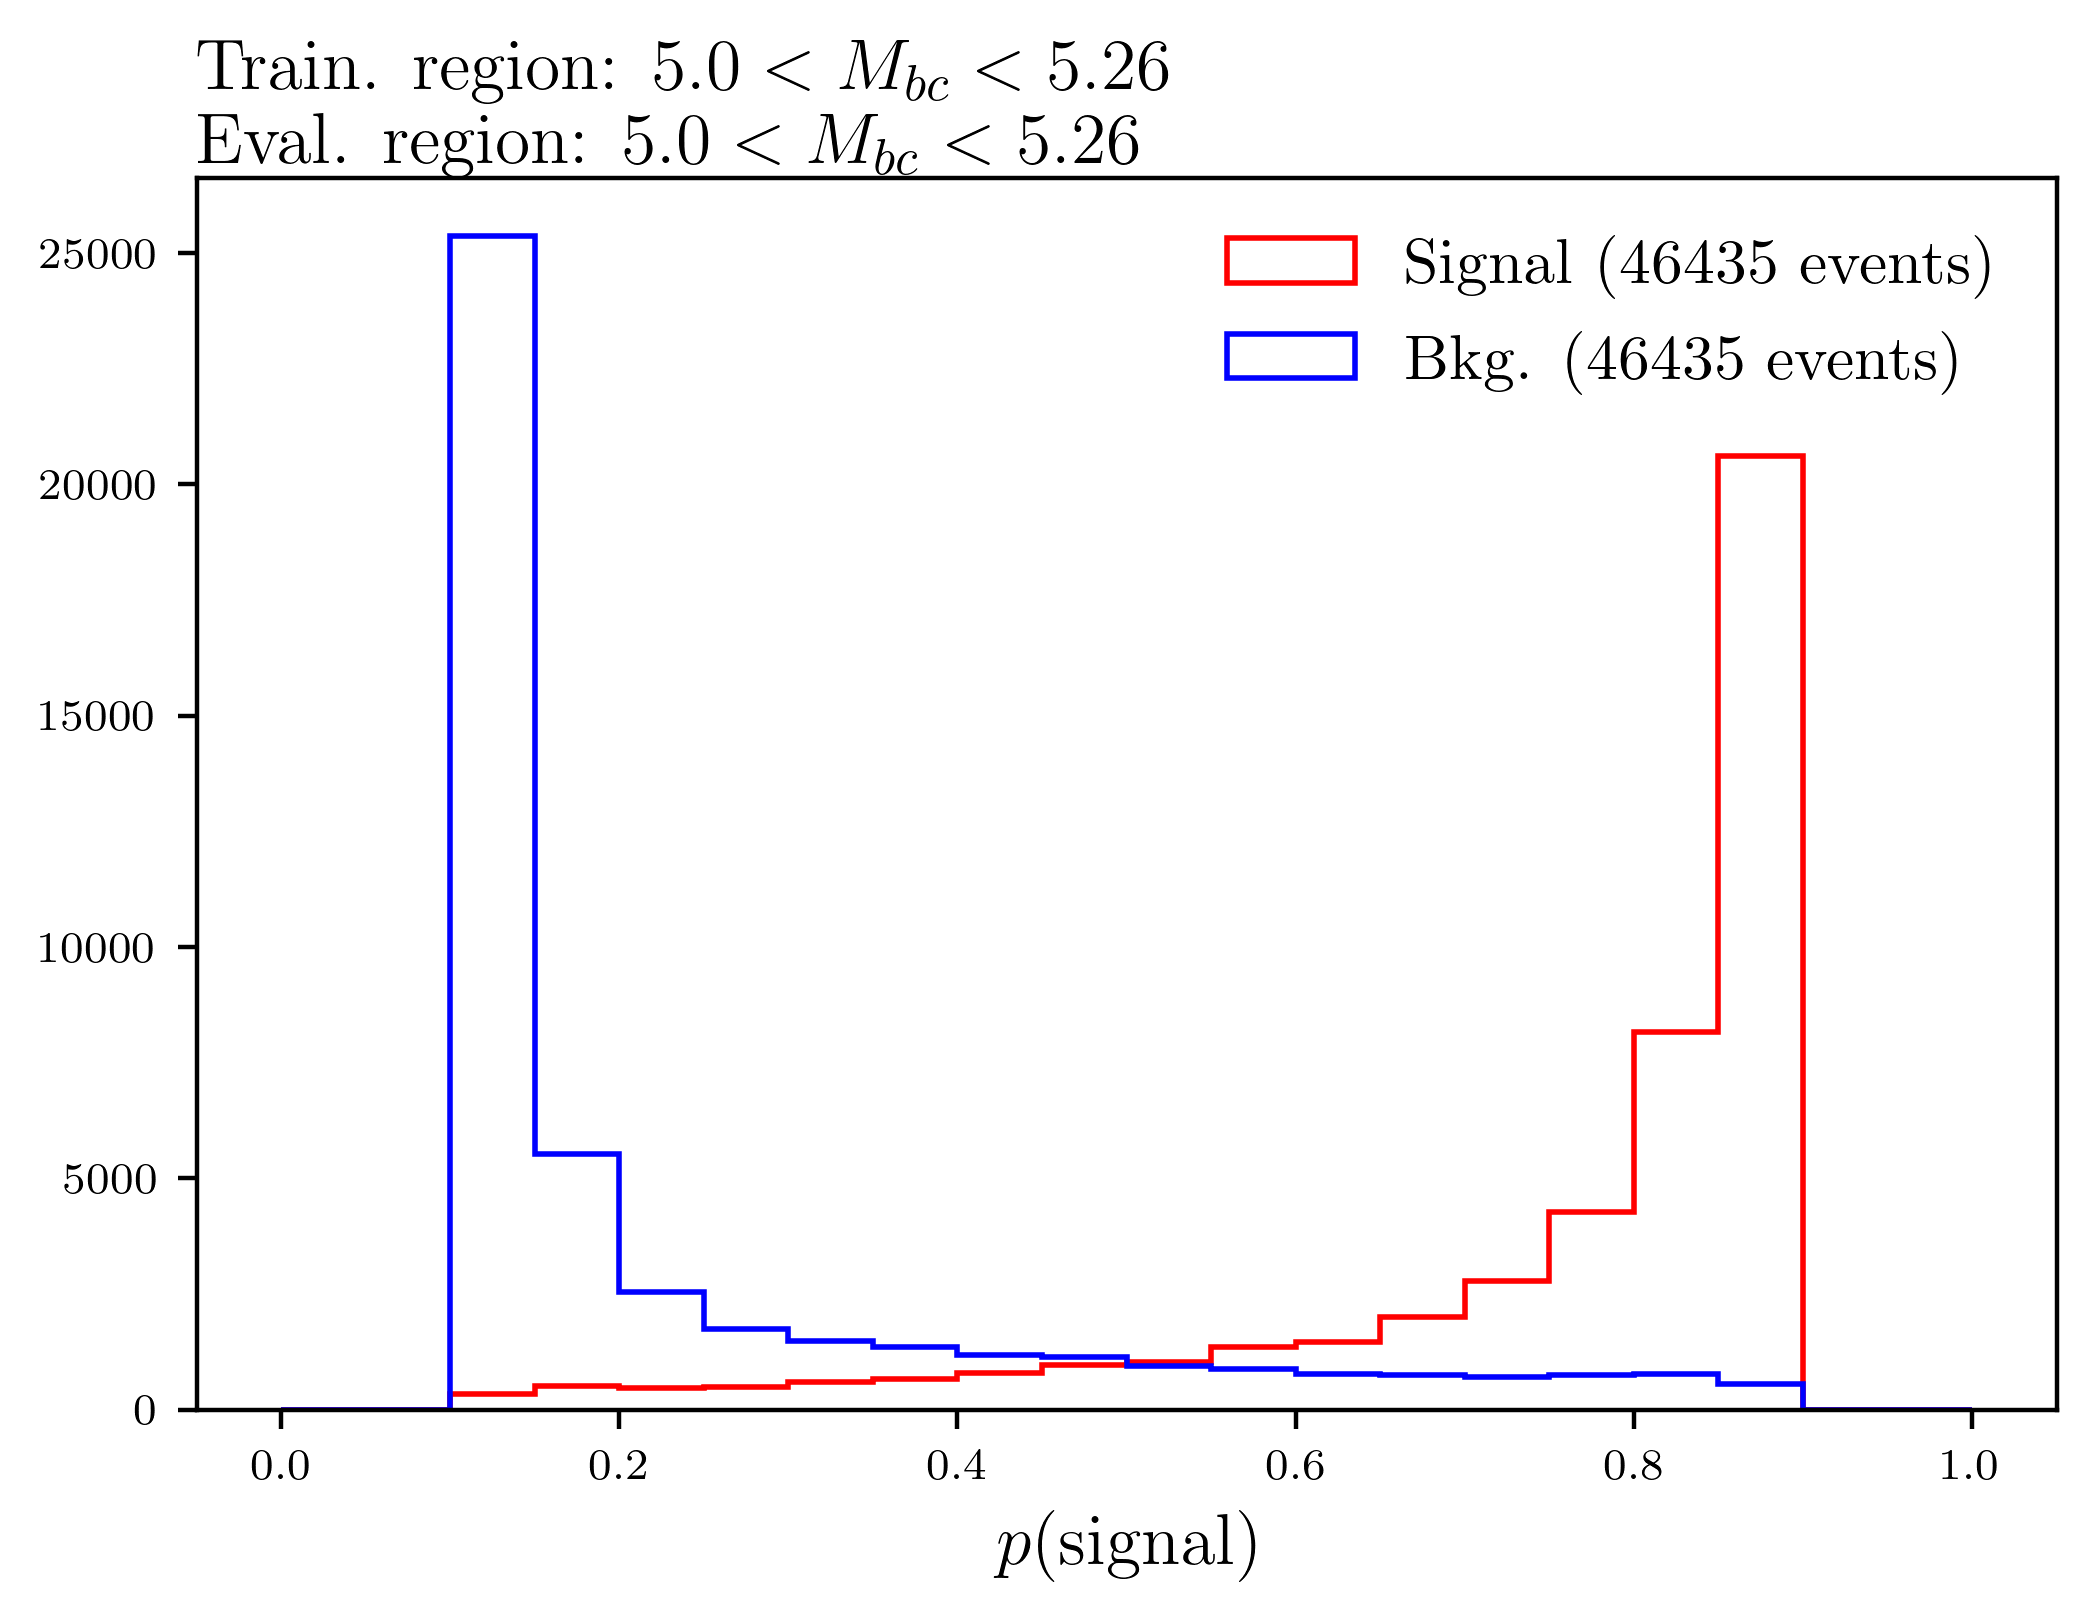

In [11]:
plt.hist(preds_sb_val_signal, label=f"Signal ({len(preds_sb_val_signal)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sb_val_bkg, label=f"Bkg. ({len(preds_sb_val_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $ 5.0 < M_{bc} < 5.26$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig("bkg_sup_sb_sb", bbox_inches="tight")

In [ ]:
preds_sb_train = predictor.predict_proba(training_dataset.drop(columns=[label])[features])
preds_sb_train_signal = preds_sb_train[training_dataset[label] == 1][1]
preds_sb_train_bkg = preds_sb_train[training_dataset[label] == 0][1]

In [ ]:
plt.hist(preds_sb_train_signal, label=f"Signal ({len(preds_sb_train_signal)} events)", color="red", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.hist(preds_sb_train_bkg, label=f"Bkg. ({len(preds_sb_train_bkg)} events)", color="blue", linestyle="-", histtype="step", range=(0,1), bins=20)
plt.title(r"Train. region: $ 5.0 < M_{bc} < 5.26$"+"\n"+ r"Eval. region: $ 5.0 < M_{bc} < 5.26$", loc="left", fontsize=13)
plt.xlabel(r"$p(\text{signal})$", fontsize=13)
plt.legend()
plt.savefig("bkg_sup_sb_sb_train", bbox_inches="tight")

In [ ]:
for i in preds_sb_train_signal, preds_sb_val_signal, preds_sr_val_signal:
    print(i.min())

In [ ]:
intervals = {
    "isSignal" : (-1, 2),
    "tfRedChiSqB0" : (-2, 20), 
    "deltaE" : (-0.1, 0.1),
    "invM_K_pi_shifted" : (-0.25, 0.25),
    "K_p_kaonID" : (0.99, 1),
    "K_p_dr" : (0, 0.03),
    "K_p_dz" : (-0.25, 0.25),
    "pi_m_dr" : (0, 0.05),
    "pi_m_dz" : (-0.25, 0.25),
    "mu_p_dr" : (0, 0.03),
    "mu_p_dz" : (-0.25, 0.25),
    "mu_p_muonID" : (0.999, 1),
    "mu_m_dr" : (0, 0.03),
    "mu_m_dz" : (-0.25, 0.25),
    "mu_m_muonID" : (0.999, 1)
}

xlabels = {
    "isSignal" : "isSignal",
    "tfRedChiSqB0" : r"Tree Fitter $\chi^2_\text{red}$", 
    "deltaE" : r"$\Delta E$",
    "invM_K_pi_shifted" : r"$M_{\text{inv}\,K\,\pi}$",
    "K_p_kaonID" : r"$K^+$: KaonID",
    "K_p_dr" : r"$K^+$: $dr$",
    "K_p_dz" : r"$K^+$: $dz$",
    "pi_m_dr" : r"$pi^-$: $dr$",
    "pi_m_dz" : r"$pi^-$: $dz$",
    "mu_p_dr" : r"$\mu^+$: $dr$",
    "mu_p_dz" : r"$\mu^+$: $dz$",
    "mu_p_muonID" : r"$\mu^+$: muonID",
    "mu_m_dr" : r"$\mu^-$: $dr$",
    "mu_m_dz" : r"$\mu^-$: $dz$",
    "mu_m_muonID" : r"$\mu^-$: muonID"
}

bins = 20

for var in validation_dataset.columns:

    val_bkg = validation_dataset[validation_dataset[label]==0]
    val_sig = validation_dataset[validation_dataset[label]==1]
    train_bkg = training_dataset[training_dataset[label]==0]
    train_sig = training_dataset[training_dataset[label]==1]

    plt.hist(val_bkg[var], color="purple", linestyle="--", histtype="step", label="Bkg. (Val.)", density=True, bins=bins, range=intervals[var])
    # plt.hist(val_sig[var], color="orange", linestyle="--", histtype="step", label="val_sig", density=True, bins=20, range=intervals[var])
    plt.hist(train_bkg[var], color="red", histtype="step", label="Bkg. (Train.)", density=True, bins=bins, range=intervals[var])
    plt.hist(train_sig[var], color="blue", histtype="step", label="Signal", density=True, bins=bins, range=intervals[var])
    plt.legend()
    plt.xlabel(xlabels[var], fontsize=14)
    plt.savefig(f"{var}.png", bbox_inches="tight")
    plt.close()

In [15]:
intervals = {
    "q_squared" : (0, 20),
    "costheta_mu" : (-1, 1),
    "costheta_K"  : (-1, 1),
    "chi" : (0, 2*numpy.pi)
}

xlabels = {
    "q_squared" : r"$q^2$",
    "costheta_mu" : r"$\cos\theta_\mu$",
    "costheta_K"  : r"$\cos\theta_K$",
    "chi" : r"$\chi$"
}

bins = 20

# bkg_sup_sr = validation_sideband_dataset[preds_sb_val[1] > 0.7]
bkg_sup_sr = validation_signal_region_dataset[preds_sr_val[1] > 0.7]
bkg_sup_sb = validation_sideband_dataset[preds_sb_val[1] < 1]

bkg_sup_sr_bkg = bkg_sup_sr[bkg_sup_sr["isSignal"] == 0]
bkg_sup_sb_bkg = bkg_sup_sb[bkg_sup_sb["isSignal"] == 0]

for var in variables:

    plt.hist(bkg_sup_sr_bkg[var], color="red", histtype="step", label=f"Bkg. Sup. Signal Region ({len(bkg_sup_sr_bkg)})", density=True, bins=bins, range=intervals[var])
    plt.hist(bkg_sup_sb_bkg[var], color="blue", histtype="step", label=f"Bkg. Sup. Sideband ({len(bkg_sup_sb_bkg)})", density=True, bins=bins, range=intervals[var])
    plt.legend()
    plt.xlabel(xlabels[var], fontsize=14)
    plt.savefig(f"{var}_sb_sr_bkg.png", bbox_inches="tight")
    plt.close()

In [ ]:
preds_sr_val[1]